In [1]:
from __future__ import print_function, division
import numpy as np
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
output_path = os.path.join('..','input')
import matplotlib.pyplot as plt
from skimage.util._montage import montage
from skimage.color import label2rgb 
os.environ["PATH"] += os.pathsep + 'D:/Users/asus/anaconda3/envs/keras/Lib/site-packages/graphviz-2.38/release/bin'
%matplotlib inline

In [2]:
import h5py
with h5py.File('all_patches.hdf5') as luna_h5:
    all_slices = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('data', all_slices.shape, 'classes', all_classes.shape)

D:\Users\asus\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  from ipykernel import kernelapp as app
D:\Users\asus\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()


data (6691, 64, 64) classes (6691, 1)


D:\Users\asus\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


Text(0.5, 1.0, 'Benign Tiles')

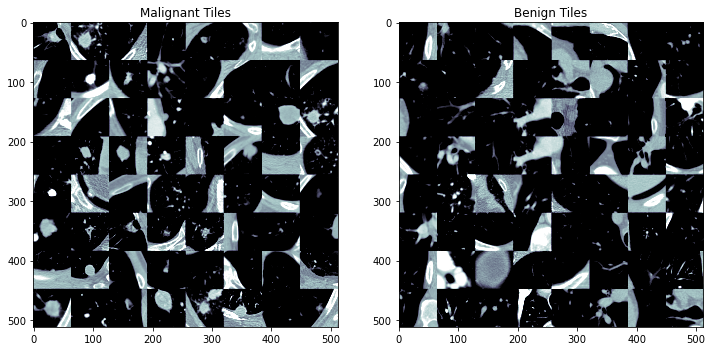

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12, 6))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
ax1.imshow(montage(all_slices[np.random.choice(np.where(all_classes>0.5)[0],size = 64)]), **plt_args)
ax1.set_title('Malignant Tiles')
ax2.imshow(montage(all_slices[np.random.choice(np.where(all_classes<0.5)[0],size = 64)]), **plt_args)
ax2.set_title('Benign Tiles')

In [4]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils
from keras.layers.merge import add

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
fire = "fire"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
#     left = BatchNormalization()(left)
#     left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
#     right = BatchNormalization()(right)
#     right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

# def fire_module2(x, fire_id, squeeze=16, expand=64):
#     s_id = 'fire' + str(fire_id) + '/'

#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = 3
    
#     x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu', name=s_id + relu + sq1x1)(x)

#     left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)

#     right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)

#     x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
#     return x

def _shortcut(x, residual):
    x_shape = K.int_shape(x)
    residual_shape = K.int_shape(residual)
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3    
    stride_width = int(round(x_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(x_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = x_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]
    
    shortcut = x
    # 如果通道数 维度不同 用1x1 conv 调节
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Convolution2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal")(x)

    return add([shortcut, residual])

def res_squeeze_block(res_squeeze_id,num_squeeze,num_expand):
    def f(x):
        residual = fire_module(x, fire_id=res_squeeze_id, squeeze=num_squeeze, expand=num_expand)
        return _shortcut(x, residual)

    return f

def ResSqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool2')(x)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = res_squeeze_block(res_squeeze_id=4, num_squeeze=16, num_expand=64)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=5, num_squeeze=16, num_expand=64)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=6, num_squeeze=16, num_expand=64)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=7, squeeze=32, expand=128)
    x = res_squeeze_block(res_squeeze_id=8, num_squeeze=32, num_expand=128)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=9, num_squeeze=32, num_expand=128)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=10, num_squeeze=32, num_expand=128)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=12, squeeze=48, expand=192)    
    x = res_squeeze_block(res_squeeze_id=13, num_squeeze=48, num_expand=192)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=14, num_squeeze=48, num_expand=192)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=15, num_squeeze=48, num_expand=192)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = fire_module(x, fire_id=16, squeeze=64, expand=256)    
    x = res_squeeze_block(res_squeeze_id=17, num_squeeze=64, num_expand=256)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=18, num_squeeze=64, num_expand=256)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = res_squeeze_block(res_squeeze_id=19, num_squeeze=64, num_expand=256)(x)
    x = BatchNormalization(center=True, scale=True)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5, name='drop19')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv20')(x)
    x = Activation('relu', name='relu_conv20')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='ResSqueezenet-20')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model
    

Using TensorFlow backend.


In [5]:
import keras
lung_node_cnn = ResSqueezeNet(input_shape = (64, 64, 1), 
                           weights = None, classes = 2,
                  use_bn_on_input = True)
# initiate RMSprop optimizer
opt = keras.optimizers.Adam(lr=0.001, decay=1e-5)

# Let's train the model using RMSprop
lung_node_cnn.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
loss_history = []
lung_node_cnn.summary()

Model: "ResSqueezenet-20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 31, 31, 64)   640         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 31, 31, 64)   0           conv1[0][0]                      
___________________________________________________________________________________

In [6]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(lung_node_cnn, to_file="D:/Users/asus/squeeze_net.png", show_shapes=True)

# Image('D:/Users/asus/squeeze_net.png')

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)

y_vec = to_categorical(all_classes)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

In [7]:
from sklearn.metrics import classification_report
y_pred_proba = lung_node_cnn.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))

lung_node_cnn.save('ResSQNet-20.h5')


              precision    recall  f1-score   support

           0       0.63      0.98      0.77      1041
           1       0.61      0.05      0.09       632

    accuracy                           0.63      1673
   macro avg       0.62      0.51      0.43      1673
weighted avg       0.62      0.63      0.51      1673



In [ ]:
for i in range(10):
    loss_history += [lung_node_cnn.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
                               shuffle = True,
                               batch_size = 32,
                               epochs = 1)]

In [ ]:
from sklearn.metrics import classification_report
y_pred_proba = lung_node_cnn.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))

In [ ]:
from IPython import display
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def get_labels(labels):
    text_labels = ['Benign', 'Malignant']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape(64,64))
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

true_labels = get_labels(np.argmax(y_test,1))
pred_labels = get_labels(y_pred)
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

for i in range(0,40,10):
    show_fashion_mnist(X_test[i:i+10], titles[i:i+10])

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()

In [ ]:
epich = np.cumsum(np.concatenate(
    [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['accuracy'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_accuracy'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')